In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [4]:
val_dataset = torchvision.datasets.DatasetFolder("Processed/val/",loader=load_file,extensions="npy",transform=val_transforms)

In [5]:
# CAM: Multiply output of last conv layer with weights of subsequent FC layer
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Convert network to generator: List
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
# Convert to pytorch model: * is to unpack layers to positional arguments
# Now have pytorch model back without last two layers
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        # Extracting feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self,data):
        feature_map = self.feature_map(data)
        # 7x7x512 -> 1x1x512
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map,output_size=(1,1))
        avg_out_flattened = torch.flatten(avg_pool_output)
        
        pred = self.model.fc(avg_out_flattened)
        
        return pred, feature_map

In [9]:
# strict = False: Did not store feature_map var in original model. PyTorch throws model otherwise
# Loads all weights it can match and ignores rest
model = PneumoniaModel.load_from_checkpoint("../AI-IN-MEDICAL-MATERIALS/04-Pneumonia-Classification/weights/weights_3.ckpt",strict=False)
model.eval(); # Semicolon = no printing model summary

C:\Users\jesus\anaconda3\envs\mytorch\lib\site-packages\pytorch_lightning\core\saving.py:205: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0

In [17]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    
    # Features: 512x7x7 -> 512 x 49
    features = features.reshape((512,49))
    # Generator containig all weights: Accessing just weights, not bias. 512 weights
    weight_params = list(model.model.fc.parameters())[0]
    # Removing gradient info from weight params
    weight = weight_params[0].detach()
    
    # Computing Class Activation Map: 
    # weight: 1x512. Features 512x49 = 49 elements output
    print(f"Weight shape is: {weight.shape} Feature shape is: {features.shape}")
    cam = torch.matmul(weight, features)
    # From 49 to 7x7
    cam_img = cam.reshape(7,7).cpu()
    
    return cam_img, torch.sigmoid(pred)

In [18]:
# x ray image, class activation map, prediction
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0),(224,224))[0]
    
    fig,axis = plt.subplots(1,2)
    
    axis[0].imshow(img,cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam,alpha=0.5,cmap="jet")
    
    plt.title((pred > 0.5).item())

In [19]:
img = val_dataset[-6][0]

activation_map, pred = cam(model,img)

Weight shape is: torch.Size([512]) Feature shape is: torch.Size([512, 49])


<IPython.core.display.Javascript object>


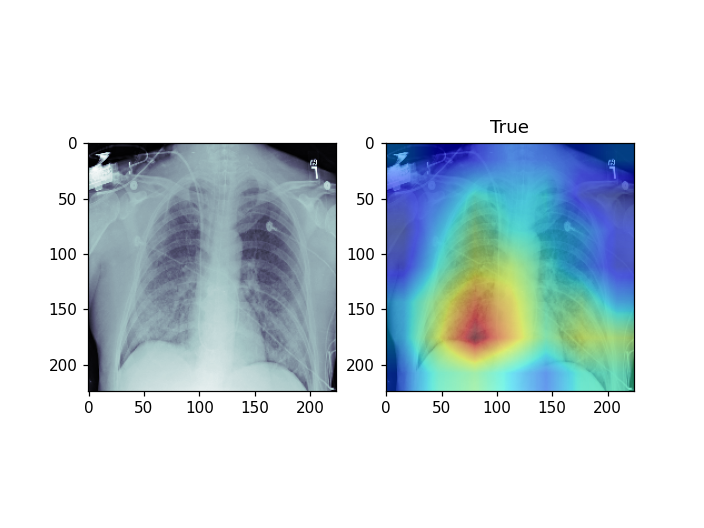

In [20]:
visualize(img, activation_map, pred)